# PyTorch dataset creation

Split `train_metadata_subset.csv` into train and test, in stratified fashion

In [1]:
!pip3 install albumentations

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [12]:
import pandas as pd
import albumentations as A
from pathlib import Path
from albumentations.core.composition import Compose, OneOf
from albumentations.pytorch import ToTensorV2

class DatasetParams:
    universe = pd.read_csv(Path("data") / "train_metadata_subset.csv")
    img_size = 512
    test_size = 0.38 # change to 0.2 later
    filepaths = {
        'train': Path("data") / "train.csv",
        'test': Path("data") / "test.csv"
    }
    imgdirpath = Path("data") / "train_images"

    # mean and std of each color channel
    # below is that of imagenet 
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]

DP = DatasetParams

DP.transforms = {
    'train': Compose([
                A.RandomResizedCrop(height=DP.img_size, width=DP.img_size),
                A.Flip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.OneOf([
                    A.RandomBrightnessContrast(p=0.5),
                    A.RandomGamma(p=0.5),
                ], p=0.5),
                A.OneOf([
                    A.Blur(p=0.1),
                    A.GaussianBlur(p=0.1),
                    A.MotionBlur(p=0.1),
                ], p=0.1),
                A.OneOf([
                    A.GaussNoise(p=0.1),
                    A.ISONoise(p=0.1),
                    A.GridDropout(ratio=0.5, p=0.2),
                    A.CoarseDropout(max_holes=16, min_holes=8, max_height=16, max_width=16, min_height=8, min_width=8, p=0.2)
                ], p=0.2),
                A.Normalize(
                    mean=DP.norm_mean,
                    std=DP.norm_std,
                ),
                ToTensorV2(),
            ]),
    
    'test': Compose([
                A.Resize(height=DP.img_size, width=DP.img_size),
                A.Normalize(
                    mean=DP.norm_mean,
                    std=DP.norm_std,
                ),
                ToTensorV2(),
            ])
}

DP.transforms_vis = {
    'train': Compose([
                A.RandomResizedCrop(height=DP.img_size, width=DP.img_size),
                A.Flip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.OneOf([
                    A.RandomBrightnessContrast(p=0.5),
                    A.RandomGamma(p=0.5),
                ], p=0.5),
                A.OneOf([
                    A.Blur(p=0.1),
                    A.GaussianBlur(p=0.1),
                    A.MotionBlur(p=0.1),
                ], p=0.1),
                A.OneOf([
                    A.GaussNoise(p=0.1),
                    A.ISONoise(p=0.1),
                    A.GridDropout(ratio=0.5, p=0.2),
                    A.CoarseDropout(max_holes=16, min_holes=8, max_height=16, max_width=16, min_height=8, min_width=8, p=0.2)
                ], p=0.2),
                ToTensorV2(),
            ]),
    
    'test': Compose([
                A.Resize(height=DP.img_size, width=DP.img_size),
                ToTensorV2(),
            ])
}

Split data into train and test 

In [3]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
import random

img_labels = DP.universe
print(len(img_labels))

# quick macro for dividing a database into two disjunct ones based on a function that returns boolean
def filter(dataframe, key, lb, yes, no):
    for i, k in enumerate(dataframe[key].tolist()):
        if lb(k):
            yes.loc[len(yes)] = dataframe.loc[i]
        else:
            if no is not None:
                no.loc[len(no)] = dataframe.loc[i]

train = pd.DataFrame(columns=['image', 'cultivar'])
test = pd.DataFrame(columns=['image', 'cultivar'])
img_to_split = pd.DataFrame(columns=['image', 'cultivar'])

# isolate all class with only 1 training sample and put them in train
counts = img_labels['cultivar'].value_counts()
print(counts)
filter(img_labels, 'cultivar', lambda cultivar: counts[cultivar] == 1, train, img_to_split)

imgs = img_to_split['image'].tolist()
labels = img_to_split['cultivar'].tolist()

print(len(imgs), len(labels))

# use train_test_split with stratify to split class with multiple training samples
train_split, test_split = train_test_split(imgs, test_size=DP.test_size, stratify=labels)
print('train', train_split)
print('test_split', test_split, len(test_split))

filter(img_to_split, 'image', lambda image: image in train_split, train, test)

print('train', train)
print('test', test)

assert(len(img_labels) == len(train) + len(test))

train.to_csv(DP.filepaths['train'], index=False)
test.to_csv(DP.filepaths['test'], index=False)

165
PI_52606     6
PI_175919    5
PI_196049    5
PI_273969    4
PI_329338    4
            ..
PI_221651    1
PI_297130    1
PI_154844    1
PI_329326    1
PI_303658    1
Name: cultivar, Length: 83, dtype: int64
133 133
train ['2017-06-28__11-30-01-893.png', '2017-06-01__10-41-04-558.png', '2017-06-15__13-11-54-968.png', '2017-06-17__13-19-07-185.png', '2017-06-19__17-31-15-431.png', '2017-06-17__12-58-37-901.png', '2017-06-29__11-50-31-536.png', '2017-06-21__14-14-01-012.png', '2017-06-18__14-41-59-638.png', '2017-06-01__11-17-06-111.png', '2017-06-17__13-18-06-932.png', '2017-06-28__11-38-42-790.png', '2017-06-02__18-15-54-053.png', '2017-06-04__13-53-43-915.png', '2017-06-29__12-22-55-083.png', '2017-06-12__13-38-25-248.png', '2017-06-21__11-43-02-157.png', '2017-06-28__10-20-19-407.png', '2017-06-12__13-20-04-699.png', '2017-06-27__10-42-43-014.png', '2017-06-26__12-56-48-642.png', '2017-06-16__11-51-23-009.png', '2017-06-03__12-29-22-146.png', '2017-06-22__13-21-19-163.png', '2017-0

In [4]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype
import cv2

class CultivarDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # NOTE: when pytorch reads an image, it is immediately transformed into a uint8 Tensor with each channel ranging in [0, 255]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image=image)['image']
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label
    

Transforms to consider and cross-validate:
- (Random) equalization
    - should it even be random?
- Color jitter in terms of:
    - Brightness
    - Contrast
    - Hue
    - Saturation
- Random rotation
- Random crop
- The order in which these functions are composed

In [5]:
import torchvision.transforms as T

Draft 1: Outdated

In [6]:
# # DO NOT USE THIS FOR TRAINING! THIS IS SOLELY USED TO VISUALIZE THE EFFECT OF TRANSFORMATIONS.
# training_data_vis = CultivarDataset(
#     annotations_file="data/train_metadata_subset.csv",
#     img_dir="data/train_images",
#     transform=T.Compose([
#         T.RandomEqualize(p=1),
#         T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
#         T.ColorJitter(brightness=.2, contrast=0),
#         T.RandomCrop(size=(500, 500)),
#         T.RandomRotation(degrees=(-180, 180)),
#         T.CenterCrop(size=(224, 224))
#     ])
# )

# training_data = CultivarDataset(
#     annotations_file="data/train_metadata_subset.csv",
#     img_dir="data/train_images",
#     transform=T.Compose([
#         T.RandomEqualize(p=1),
#         T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
#         # T.ColorJitter(brightness=.5, contrast=.7),
#         T.RandomCrop(size=(500, 500)),
#         T.RandomRotation(degrees=(-180, 180)),
#         T.CenterCrop(size=(224, 224)),
#         T.Normalize(norm_mean, norm_std)
#     ])
# )

Draft 2: Outdated

In [7]:

# # DO NOT USE THIS FOR TRAINING! THIS IS SOLELY USED TO VISUALIZE THE EFFECT OF TRANSFORMATIONS.
# training_data_vis = CultivarDataset(
#     annotations_file="data/train_metadata_subset.csv",
#     img_dir="data/train_images",
#     transform=T.Compose([
#         T.RandomEqualize(p=1),
#         T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
#         T.RandomRotation(degrees=(-15, 15)),
#         T.RandomHorizontalFlip(p=0.5),
#         T.RandomVerticalFlip(p=0.5),
#         T.Resize(size=(224, 224))
#     ])
# )

# # USE THIS INSTEAD
# training_data = CultivarDataset(
#     annotations_file=annotation_file_path,
#     img_dir=img_dir_path,
#     transform=T.Compose([
#         T.RandomEqualize(p=1),
#         T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
#         # T.ColorJitter(brightness=.5, contrast=.7),
#         T.RandomRotation(degrees=(-15, 15)),
#         T.RandomHorizontalFlip(p=0.5),
#         T.RandomVerticalFlip(p=0.5),
#         T.Resize(size=(224, 224)),
#         T.Normalize(norm_mean, norm_std)
#     ])
# )

Current version

In [14]:
# DO NOT USE THIS FOR TRAINING! THIS IS SOLELY USED TO VISUALIZE THE EFFECT OF TRANSFORMATIONS.
datasets_vis = {
    'train': CultivarDataset(
                annotations_file=DP.filepaths['train'],
                img_dir=DP.imgdirpath,
                transform=DP.transforms_vis['train']
            ),
    'test': CultivarDataset(
                annotations_file=DP.filepaths['test'],
                img_dir=DP.imgdirpath,
                transform=DP.transforms_vis['test']
            )
}

# USE THIS INSTEAD
datasets = {
    'train': CultivarDataset(
                annotations_file=DP.filepaths['train'],
                img_dir=DP.imgdirpath,
                transform=DP.transforms['train']
            ),
    'test': CultivarDataset(
                annotations_file=DP.filepaths['test'],
                img_dir=DP.imgdirpath,
                transform=DP.transforms['test']
            )
}

What the transform does to individual images (uses uint8, before normalization)

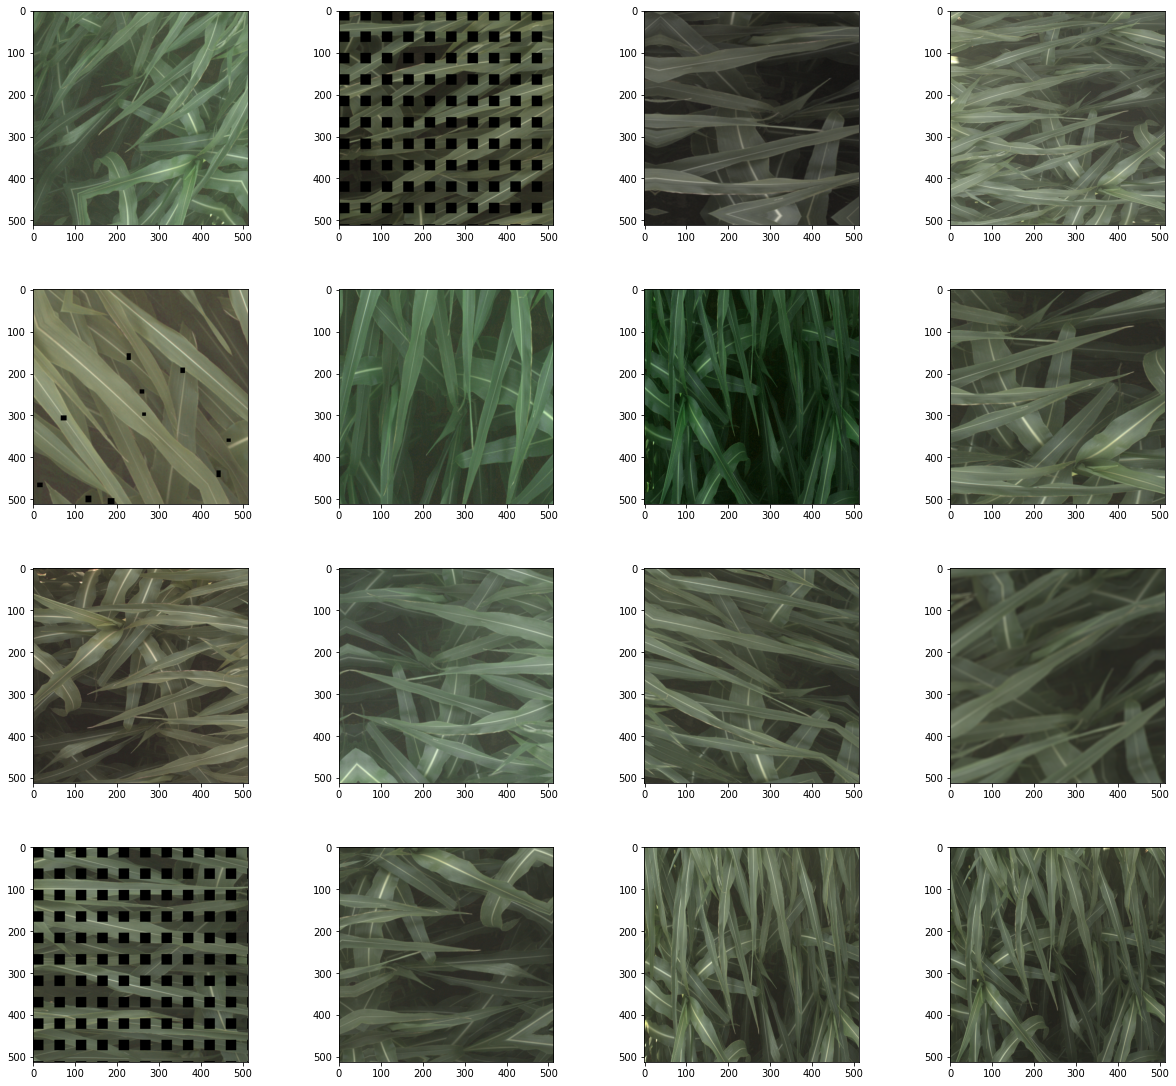

In [15]:
import matplotlib.pyplot as plt
from numpy import transpose

figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 4
plt.subplots_adjust(left=0.13, right=0.93, top=1.0, bottom= 0.27, wspace= 0.3, hspace=0.3)
for i in range(1, cols * rows + 1):
    # sample_idx = torch.randint(len(training_data), size=(1,)).item()
    sample_idx = 0
    img, label = datasets_vis['train'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(transpose(img.numpy(), (1,2,0)))
plt.show()


Visualize just the red channel, after normalization (uses float)

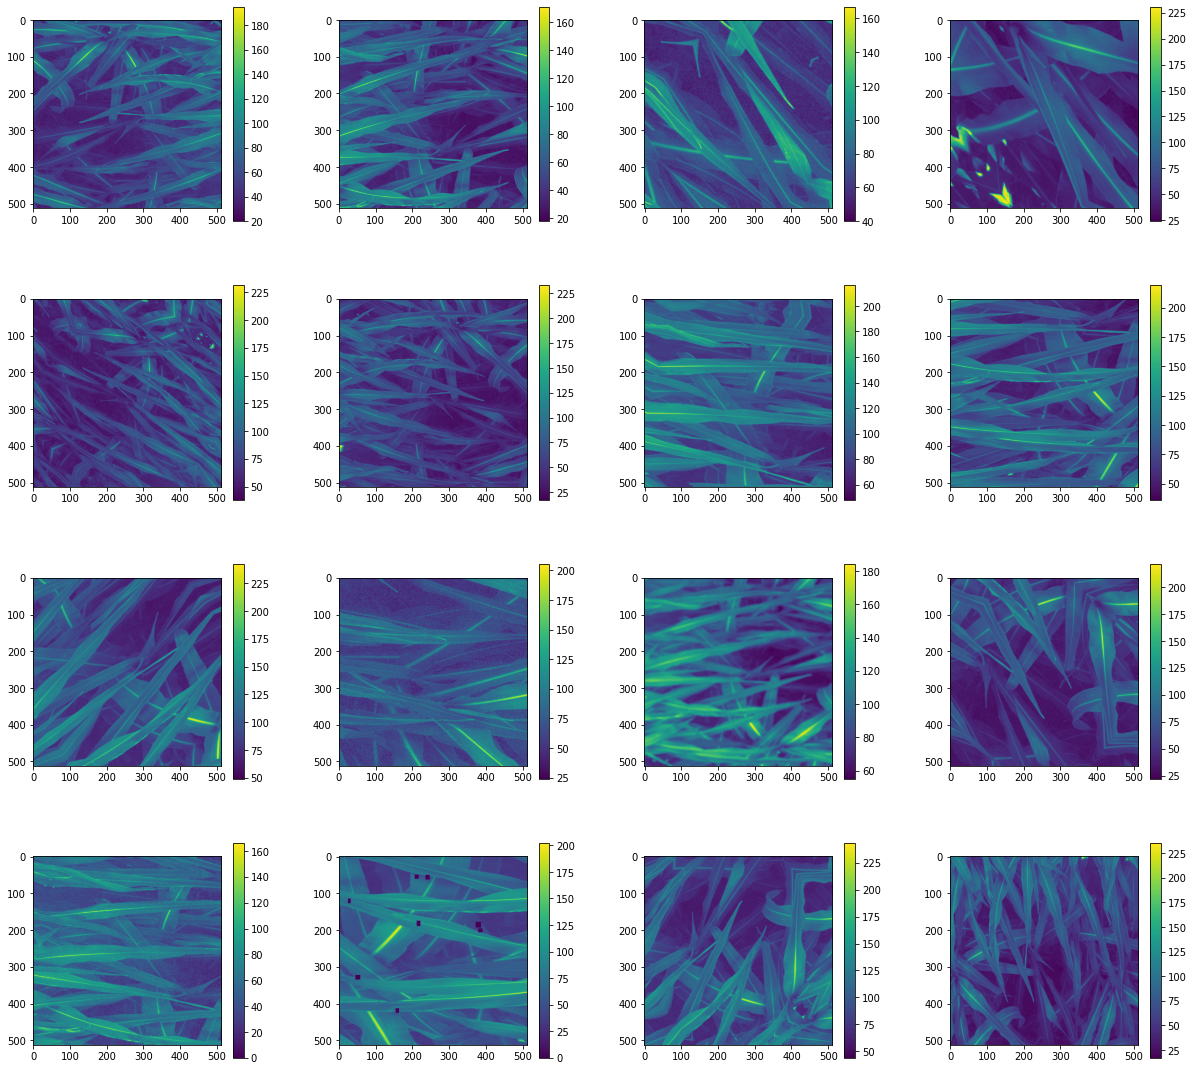

In [16]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 4
plt.subplots_adjust(left=0.13, right=0.93, top=1.0, bottom= 0.27, wspace= 0.3, hspace=0.3)
for i in range(1, cols * rows + 1):
    # sample_idx = torch.randint(len(training_data), size=(1,)).item()
    sample_idx = 0
    img, label = datasets_vis['train'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze()[0])
    plt.colorbar()
plt.show()


Effect on random different images in the dataset 

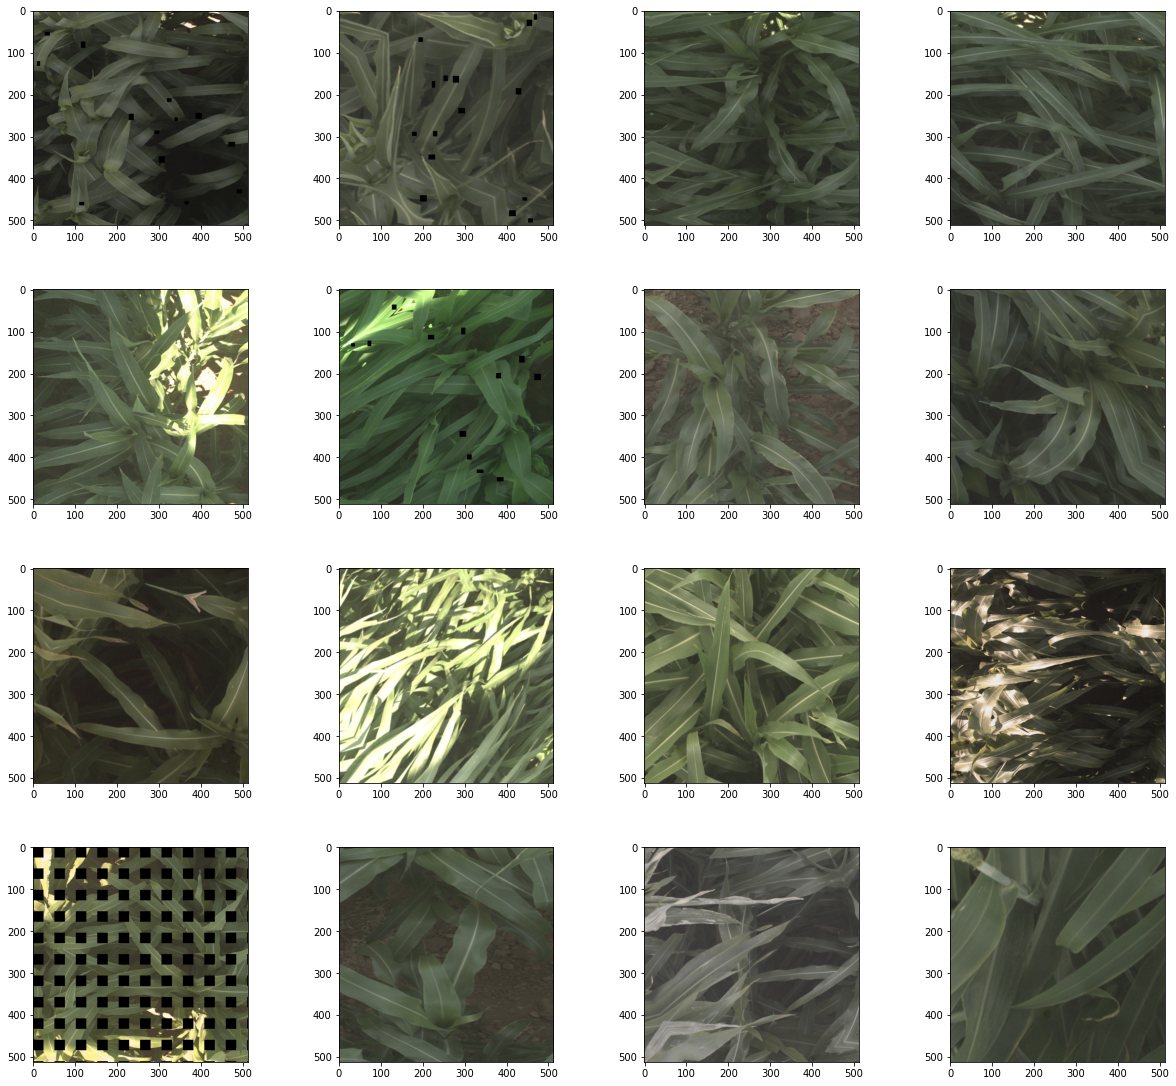

In [24]:
import matplotlib.pyplot as plt
from numpy import transpose

figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 4
plt.subplots_adjust(left=0.13, right=0.93, top=1.0, bottom= 0.27, wspace= 0.3, hspace=0.3)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(datasets_vis['train']), size=(1,)).item()
    img, label = datasets_vis['train'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(transpose(img.numpy(), (1,2,0)))
plt.show()

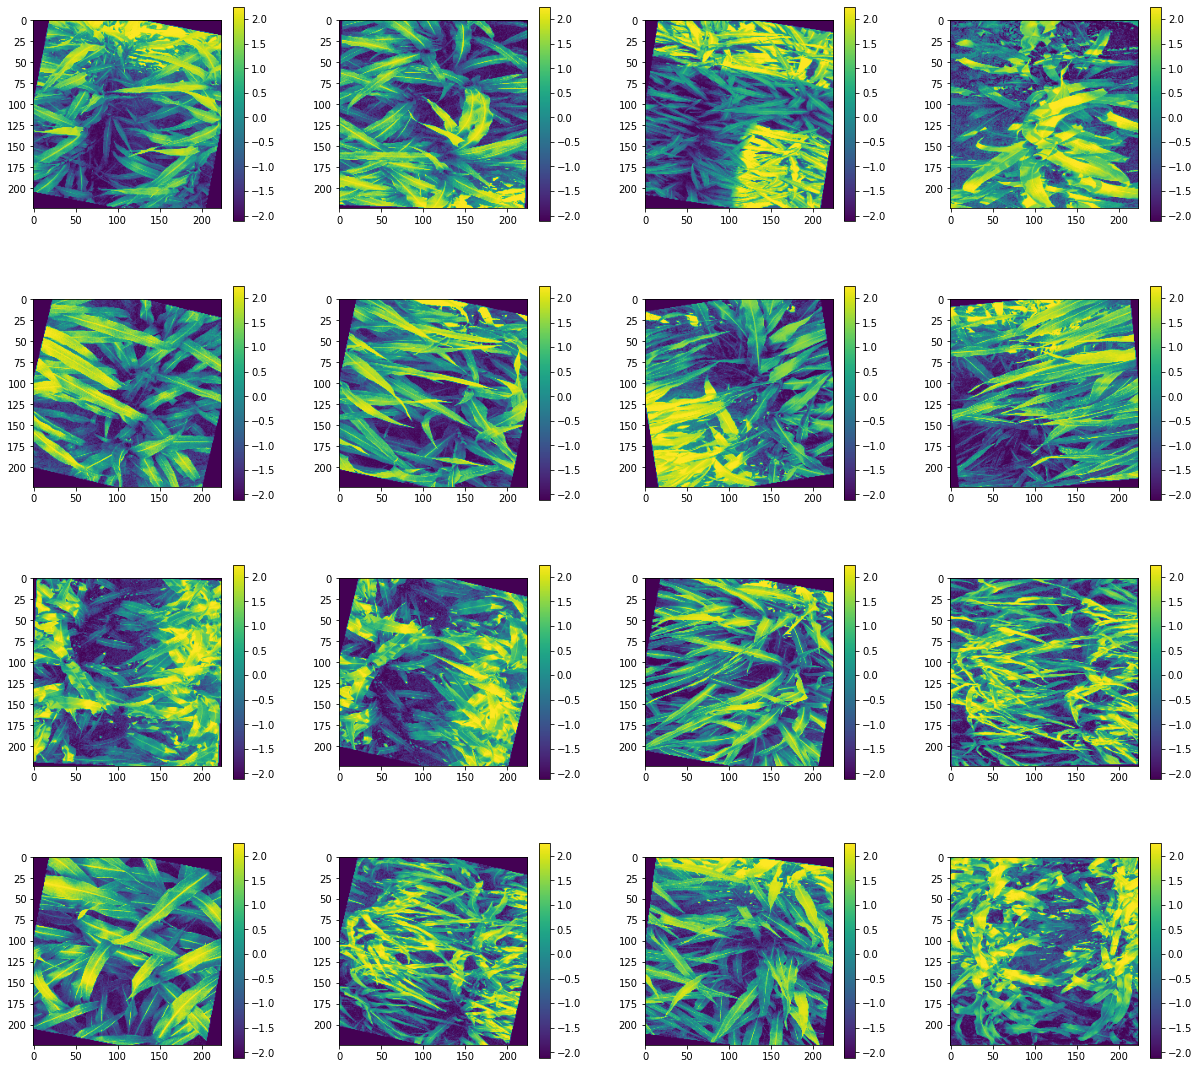

In [ ]:
figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 4
plt.subplots_adjust(left=0.13, right=0.93, top=1.0, bottom= 0.27, wspace= 0.3, hspace=0.3)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = dataset_vis['train'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze()[0])
    plt.colorbar()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d841b2e3-7f2f-42e6-ae8e-6cea1c0a3631' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>